In [1]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller, kpss

In [2]:
import sys
sys.path.append("../") # go to parent dir
sys.path.append('/home/artem/git/sdafe')

In [17]:
from common.plot_ccf import plot_accf
from ch14.utils import plot_residuals
from sdafe.r import tl, fv, el

In [4]:
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri, numpy2ri, default_converter

np_cv_rules = default_converter + numpy2ri.converter

### 14.16.1 Fitting GARCH Models

In [53]:
data = pd.read_csv('../data/TbGdpPi.csv')
data.index = pd.date_range(start='1955', freq='Q', periods=data.shape[0])
data.head()
# r = the 91-day Treasury bill rate
# y = the log of real GDP
# pi = the inflation rate

,r,y,pi
1955-03-31,1.41,7.894976,0.000000
1955-06-30,1.47,7.911123,0.000000
1955-09-30,2.15,7.924480,0.749064
1955-12-31,2.50,7.930480,-0.371747
1956-03-31,2.30,7.926614,0.000000


In [54]:
tbill = data['r']
tbill_diff = tbill.diff().dropna()

#### Problem 1

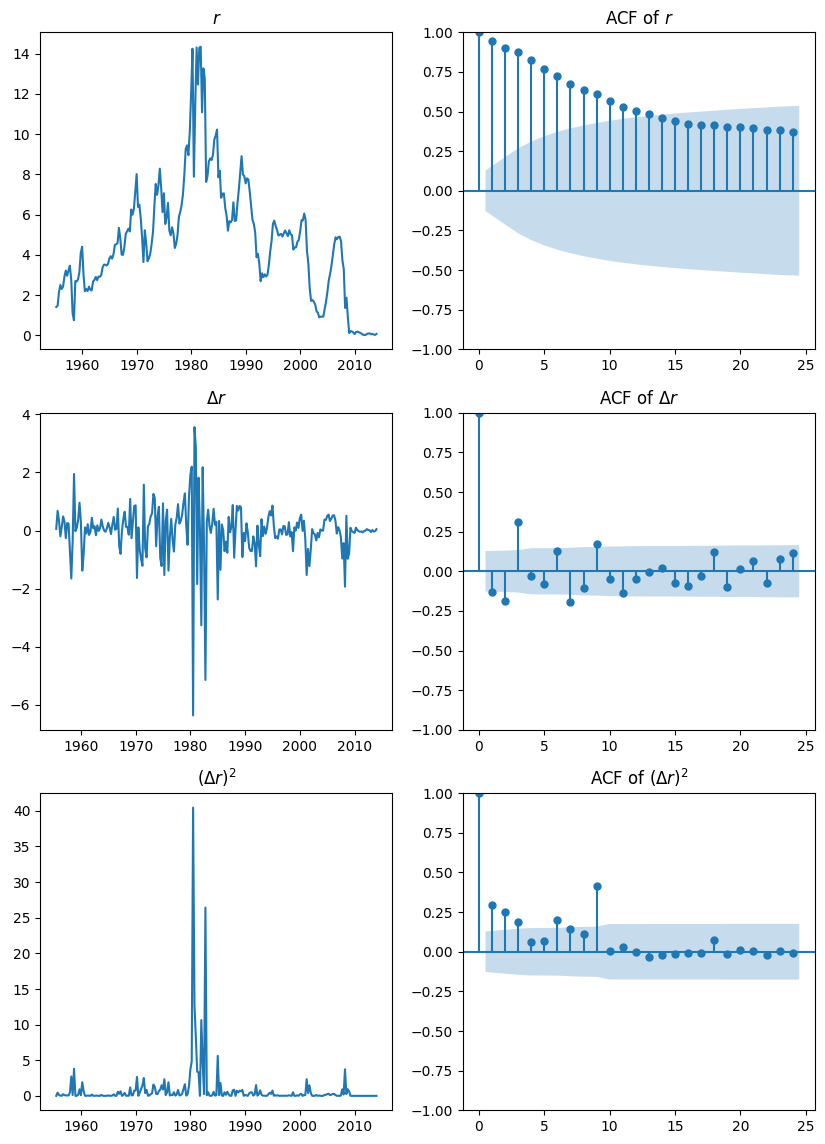

In [55]:
fig, axs = plt.subplots(3, 2, figsize=(10, 14))

axs[0][0].plot(tbill);
axs[0][0].set_title('$r$');

plot_acf(tbill, ax=axs[0][1]);
axs[0][1].set_title('ACF of $r$');

axs[1][0].plot(tbill_diff);
axs[1][0].set_title('$\\Delta r$');

plot_acf(tbill_diff, ax=axs[1][1]);
axs[1][1].set_title('ACF of $\\Delta r$');

axs[2][0].plot(tbill_diff ** 2);
axs[2][0].set_title('$(\\Delta r)^2$');

plot_acf(tbill_diff ** 2, ax=axs[2][1]);
axs[2][1].set_title('ACF of $(\\Delta r)^2$');

The augmented Dickey-Fuller test for the original time series does not reject the null hypothesis of a unit root and hence non-stationarity:

In [56]:
adfuller(tbill, maxlag=6, autolag=None, regression='ct')  #  the parameters are set to match the behaviour in R

(-2.562223628194525,
 0.297581682815403,
 6,
 229,
 {'1%': -3.998856453913814,
  '5%': -3.429838138665128,
  '10%': -3.138417539315758})

For the differenced time series, the null hypothesis is rejected:

In [57]:
adfuller(tbill_diff, maxlag=6, autolag=None, regression='ct')  #  the parameters are set to match the behaviour in R

(-6.342456951976649,
 4.0742646378145134e-07,
 6,
 228,
 {'1%': -3.9990347583703216,
  '5%': -3.4299237913352556,
  '10%': -3.138467743111241})

The KPSS test rejects the null hypothesis of stationarity for the original time series at 5% level:

In [58]:
kpss(tbill, nlags=4, regression='c')  #  the parameters are set to match the behaviour in R

/home/artem/Study/SDAFE/venv/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


(1.0719081748803925,
 0.01,
 4,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

For the differenced time series, KPSS does not reject the null hypothesis:

In [59]:
kpss(tbill_diff, nlags=4, regression='c')  #  the parameters are set to match the behaviour in R

/home/artem/Study/SDAFE/venv/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


(0.1496706247363345,
 0.1,
 4,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

The plot of $\Delta r$ suggests periods of persisten volatility rather than short bursts, and so calls for a GARCH model.

#### Problem 2

(a) We fit an AR(1)+GARCH(1,1) model:
$$
\begin{equation}
\begin{split}
Y_t &=& \texttt{mu} + \texttt{ar1} \cdot (Y_{t-1} - \texttt{mu}) + a_t, \\
a_t &=& \sigma_t \epsilon_t, \\
\sigma_t^2 &=& \texttt{omega} + \texttt{alpha1} \cdot a_{t-1}^2 + \texttt{beta1} \cdot \sigma_{t-1}^2, \\
\epsilon_t &\sim& N(0, 1)
\end{split}
\end{equation}
$$

In [60]:
rugarch = importr('rugarch')
rmethods = importr('methods')
rstats = importr('stats')

In [64]:
arma_garch_norm = rugarch.ugarchspec(mean_model=tl({'armaOrder': fv(1, 0)}), variance_model=tl({'garchOrder': fv(1, 1)}))
with np_cv_rules.context():
    tbill_arma_garch_norm = rugarch.ugarchfit(data=tbill_diff.values, spec=arma_garch_norm)
rmethods.show(tbill_arma_garch_norm)


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(1,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.018556    0.032524  0.57054 0.568313
ar1     0.139618    0.069092  2.02075 0.043306
omega   0.016961    0.010715  1.58296 0.113430
alpha1  0.383655    0.065991  5.81378 0.000000
beta1   0.615345    0.041021 15.00090 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.018556    0.039885  0.46525 0.641753
ar1     0.139618    0.117234  1.19093 0.233681
omega   0.016961    0.030675  0.55293 0.580308
alpha1  0.383655    0.128735  2.98019 0.002881
beta1   0.615345    0.077928  7.89630 0.000000

LogLikelihood : -223.8331 

Information Criteria
------------------------------------
               

<rpy2.robjects.methods.RS4 object at 0x7f13640d3f10> [25]
R classes: ('uGARCHfit',)

(b) The estimates are:

| Parameter | Estimate |
|-----------|----------|
| mu        | 0.018556 |
| ar1       | 0.139618 |
| omega     | 0.016961 |
| alpha1    | 0.383655 |
| beta1     | 0.615345 |

Note that the estimates for `mu`, `ar1` and `omega` are not significant.

#### Problem 3

In [65]:
with np_cv_rules.context():
    res = pd.Series(tbill_arma_garch_norm.slots['fit']['residuals'], index=tbill_diff.index)
    res_std = res / tbill_arma_garch_norm.slots['fit']['sigma']

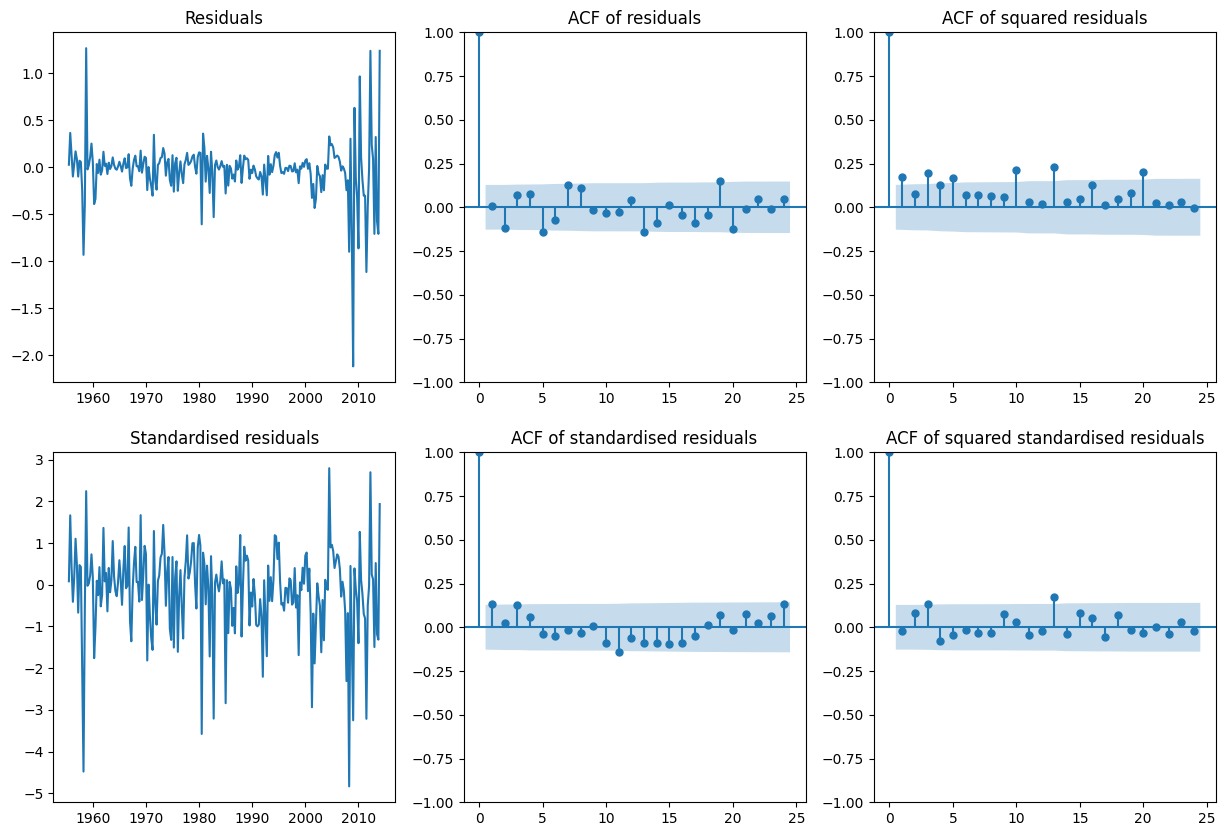

In [103]:
plot_residuals(res, res_std)

(a) The ACF of residuals shows that the AR model alone does not account for the full autocorrelation structure in the data.

(b) The ACF of squared residuals shows evidence of conditional heterskedasticity in the data.

(c) The ACF of squared standardised residuals shows that the GARCH component accounts well for the correlations in the residuals.

(d) There appear to be more pronouced negative standardised residuals, which might call for an asymmetric GARCH model.

#### Problem 4

In [67]:
tbill_log_diff = np.log(tbill).diff().dropna()

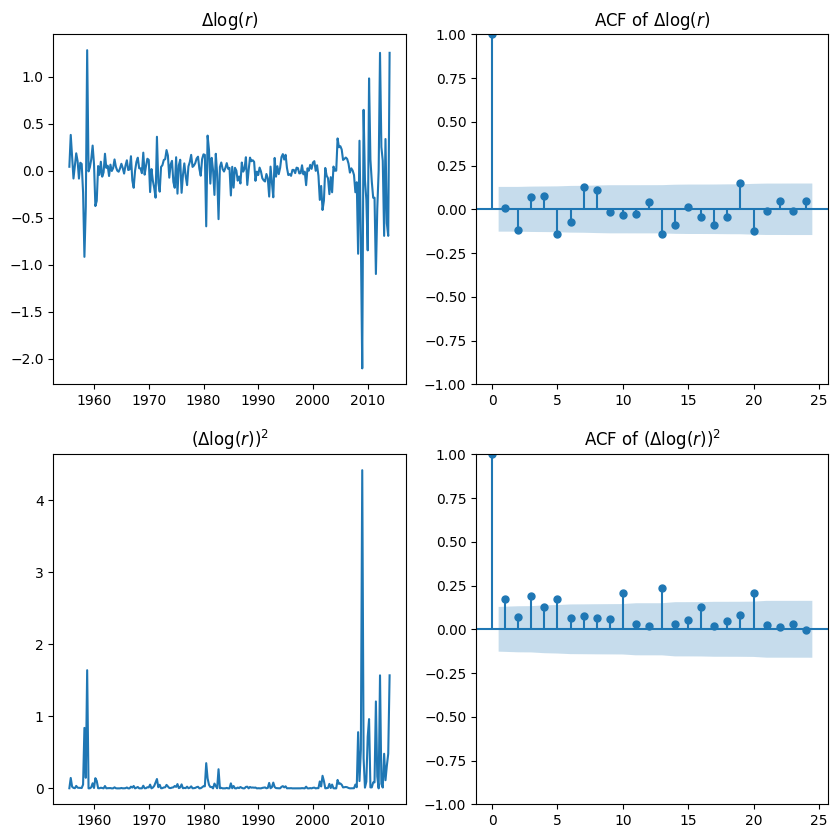

In [68]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0][0].plot(tbill_log_diff);
axs[0][0].set_title('$\\Delta \\log(r)$');

plot_acf(tbill_log_diff, ax=axs[0][1]);
axs[0][1].set_title('ACF of $\\Delta \\log(r)$');

axs[1][0].plot(tbill_log_diff ** 2);
axs[1][0].set_title('$(\\Delta \\log(r))^2$');

plot_acf(tbill_log_diff ** 2, ax=axs[1][1]);
axs[1][1].set_title('ACF of $(\\Delta \\log(r))^2$');

We see that differencing the log of $r$ removes most of the serial autocorrelation in the time series, so a simple white noise might be adequate. The squared values still show autocorrelation, suggesting a GARCH model.

Augmented Dickey-Fuller test rejects the existence of a unit root, implying the stationarity of the series:

In [70]:
adfuller(tbill_log_diff, maxlag=6, autolag=None, regression='ct')  #  the parameters are set to match the behaviour in R

(-5.891286821722967,
 3.7062837629077785e-06,
 6,
 228,
 {'1%': -3.9990347583703216,
  '5%': -3.4299237913352556,
  '10%': -3.138467743111241})

The same conclusion is supported by the results of the KPSS test:

In [71]:
kpss(tbill_log_diff, nlags=4, regression='c')  #  the parameters are set to match the behaviour in R

/home/artem/Study/SDAFE/venv/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


(0.3317779032684428,
 0.1,
 4,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Ljung-Box rejects the hypothesis of no autocorrelation, although the conclusion fluctuates with the lag:

In [72]:
acorr_ljungbox(tbill_log_diff, lags=24)

,lb_stat,lb_pvalue
1,0.008670,0.925815
2,3.358000,0.186560
3,4.566630,0.206423
4,6.002208,0.198983
5,10.808653,0.055309
6,12.109361,0.059573
7,15.898156,0.026063
8,18.973063,0.015004
9,19.018881,0.025033
10,19.287990,0.036754


Fitting AR(1)+GARCH(1, 1) confirms that the AR coefficient is not significant:

In [73]:
arma_garch_norm = rugarch.ugarchspec(mean_model=tl({'armaOrder': fv(1, 0)}), variance_model=tl({'garchOrder': fv(1, 1)}))
with np_cv_rules.context():
    fit2 = rugarch.ugarchfit(data=tbill_log_diff.values, spec=arma_garch_norm)
rmethods.show(fit2)


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(1,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.015687    0.009638   1.6277  0.10360
ar1     0.100402    0.074611   1.3457  0.17841
omega   0.004274    0.001434   2.9813  0.00287
alpha1  0.497553    0.093795   5.3047  0.00000
beta1   0.501447    0.073451   6.8270  0.00000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.015687    0.013789  1.13765 0.255268
ar1     0.100402    0.114556  0.87644 0.380789
omega   0.004274    0.002619  1.63191 0.102699
alpha1  0.497553    0.176017  2.82673 0.004703
beta1   0.501447    0.136196  3.68182 0.000232

LogLikelihood : 52.01162 

Information Criteria
------------------------------------
                

<rpy2.robjects.methods.RS4 object at 0x7f136440e250> [25]
R classes: ('uGARCHfit',)

We can therefore fit a white noise model for the mean:

In [74]:
arma_garch_norm = rugarch.ugarchspec(mean_model=tl({'armaOrder': fv(0, 0)}), variance_model=tl({'garchOrder': fv(1, 1)}))
with np_cv_rules.context():
    fit3 = rugarch.ugarchfit(data=tbill_log_diff.values, spec=arma_garch_norm)
rmethods.show(fit3)


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.016481    0.008982   1.8350 0.066511
omega   0.004632    0.001558   2.9731 0.002948
alpha1  0.529395    0.098609   5.3686 0.000000
beta1   0.469605    0.079101   5.9368 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.016481    0.013314   1.2379 0.215752
omega   0.004632    0.002771   1.6714 0.094642
alpha1  0.529395    0.184450   2.8701 0.004103
beta1   0.469605    0.143755   3.2667 0.001088

LogLikelihood : 51.09497 

Information Criteria
------------------------------------
                     
Akaike       -0.40081
Bayes        -0.34192
Shibata      -0.40137
Hannan-Quinn -0.37707


<rpy2.robjects.methods.RS4 object at 0x7f13642b6e50> [25]
R classes: ('uGARCHfit',)

In [75]:
with np_cv_rules.context():
    res = pd.Series(fit3.slots['fit']['residuals'], index=tbill_log_diff.index)
    res_std = res / fit3.slots['fit']['sigma']

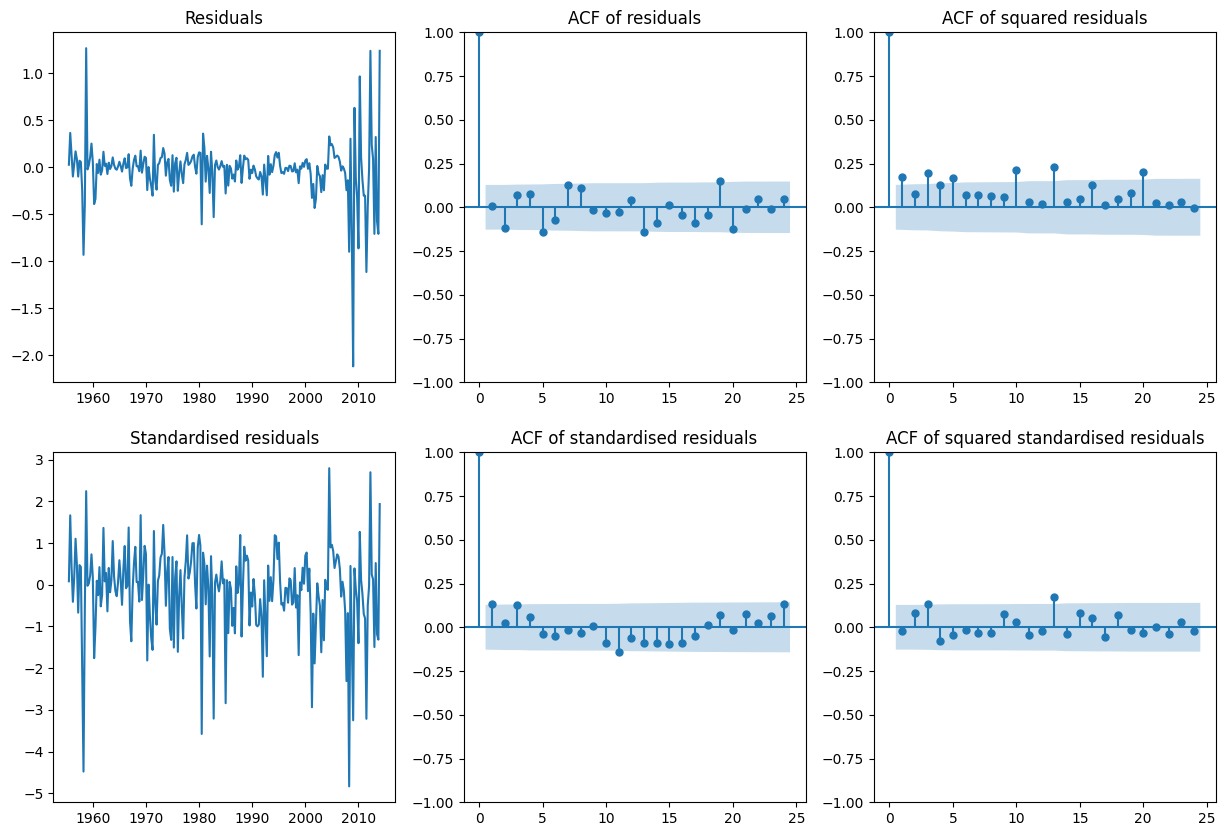

In [104]:
plot_residuals(res, res_std)

The advantage of using the transformed time series lies in removing a significant amount of serial autocorrelation before applying any sophisticated calculation.

### 14.16.2 The GARCH-in-Mean (GARCH-M) Model

In [77]:
data = pd.read_csv('../data/GPRO.csv', header=None)
data.head()

,0
0,0.141034
1,0.133949
2,0.203453
3,-0.138525
4,-0.010942


In [78]:
garchm = rugarch.ugarchspec(mean_model=tl({'armaOrder': fv(0, 0), 'archm': True, 'archpow': 1}), variance_model=tl({'garchOrder': fv(1, 1)}))
with np_cv_rules.context():
    gpro_garchm = rugarch.ugarchfit(data=data[0].values, spec=garchm)
rmethods.show(gpro_garchm);


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu     -0.102834    0.030822  -3.3363 0.000849
archm   2.096883    0.598782   3.5019 0.000462
omega   0.000963    0.000514   1.8739 0.060938
alpha1  0.000000    0.044860   0.0000 1.000000
beta1   0.613498    0.215874   2.8419 0.004484

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu     -0.102834    0.018730  -5.4903 0.000000
archm   2.096883    0.318062   6.5927 0.000000
omega   0.000963    0.000398   2.4172 0.015640
alpha1  0.000000    0.056748   0.0000 1.000000
beta1   0.613498    0.186034   3.2978 0.000975

LogLikelihood : 229.9842 

Information Criteria
------------------------------------
                

#### Problem 5

Using p-values based on robust standard errors, we cannot reject the null hypothesis that `alpha1` is zero.

The resulting model is then:
$$
\begin{equation}
\begin{split}
Y_t &=& -0.102834 + 2.096883 \sigma_t + a_t \\
a_t &=& \sigma_t \epsilon_t \\
\sigma_t^2 &=& 0.000963 + 0.613498 \sigma_{t-1}^2
\end{split}
\end{equation}
$$

#### Problem 6

NB: p-values reported by GARCH fit are calculated using the CDF of the normal distribution, rather than t, e.g. for `archm` using non-robust estimates:

In [79]:
with np_cv_rules.context():
    coefs = gpro_garchm.slots['fit']['matcoef']

The p-value reported is:

In [80]:
coefs[1, 3]

0.0004619283037332611

The p-value calculated from the t-value reported:

In [81]:
2 * stats.norm.cdf(-coefs[1, 2])

0.00046192830373325004

The p-value of the one-sided test is then:

In [82]:
stats.norm.cdf(-coefs[1, 2])

0.00023096415186662502

Therefore, we reject the null hypothesis that $\delta = 0$.

### 14.16.3 Fitting Multivariate GARCH Models

In [83]:
data = pd.read_csv('../data/TbGdpPi.csv')
data.index = pd.date_range(start='1955', freq='Q', periods=data.shape[0])
data.head()
# r = the 91-day Treasury bill rate
# y = the log of real GDP
# pi = the inflation rate

,r,y,pi
1955-03-31,1.41,7.894976,0.000000
1955-06-30,1.47,7.911123,0.000000
1955-09-30,2.15,7.924480,0.749064
1955-12-31,2.50,7.930480,-0.371747
1956-03-31,2.30,7.926614,0.000000


In [84]:
tb_pi_diff = data[['r', 'pi']].diff().dropna()

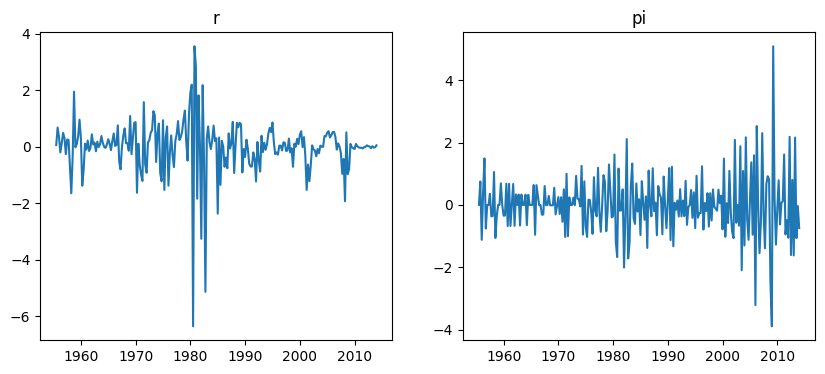

In [85]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(tb_pi_diff['r']);
axs[0].set_title('r');
axs[1].plot(tb_pi_diff['pi']);
axs[1].set_title('pi');

#### Problem 7

We can see that $\Delta r$ and $\Delta pi$ have auto- and cross-correlations:

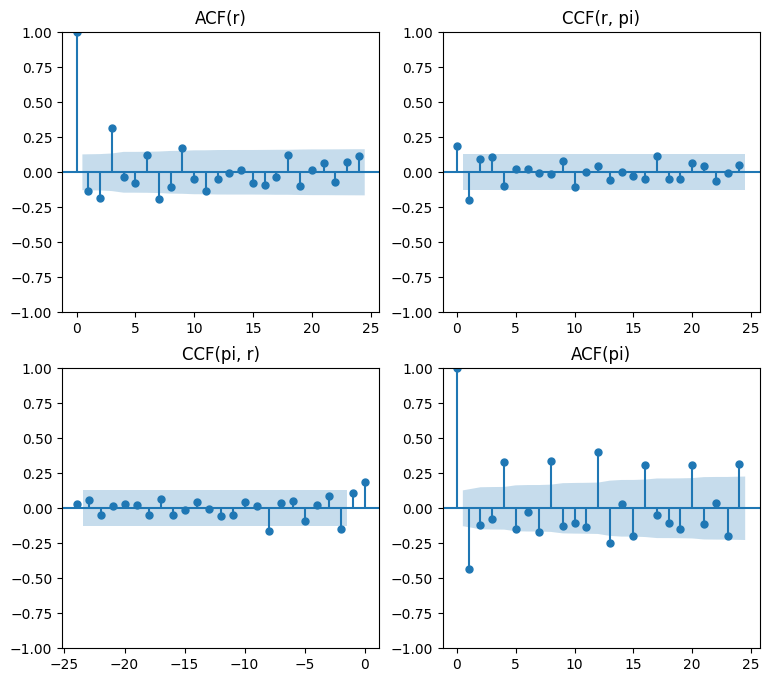

In [86]:
fig = plt.figure(figsize=(9, 8));
plot_accf(tb_pi_diff, fig=fig);

But $(\Delta r)^2$ and $(\Delta pi)^2$ only have autocorrelations:

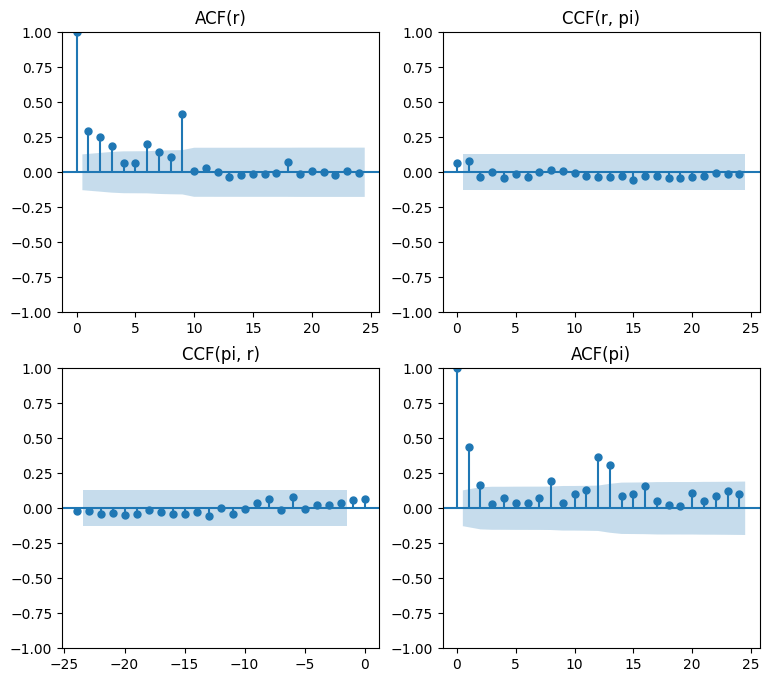

In [87]:
fig = plt.figure(figsize=(9, 8));
plot_accf(tb_pi_diff ** 2, fig=fig);

In [88]:
MTS = importr('MTS')

The multivariate Ljung-Box test rejects the hypothesis of no correlation:

In [89]:
with np_cv_rules.context():
    MTS.mq(tb_pi_diff.values ** 2, lag=8)

Ljung-Box Statistics:  
       m       Q(m)     df    p-value
[1,]   1.0      66.2     4.0        0
[2,]   2.0      88.5     8.0        0
[3,]   3.0      97.3    12.0        0
[4,]   4.0     100.3    16.0        0
[5,]   5.0     101.9    20.0        0
[6,]   6.0     113.3    24.0        0
[7,]   7.0     119.8    28.0        0
[8,]   8.0     132.6    32.0        0


Based on the plots and the results of the Ljung-Box test for the squared time series, we conclude that the joint series exhibits conditional heterskedasticity.

#### Problem 8

In [90]:
from sdafe.ch14.ewma import est_ewma, sigma_ewma

In [91]:
ewma_param = est_ewma(0.95, tb_pi_diff.values)
ewma_sigma = sigma_ewma(ewma_param[0], tb_pi_diff.values)

The estimated persistence parameter is

In [92]:
ewma_param[0]

0.8665829086488697

In [93]:
def plot_sigma(ax, sigma, index, title):
    ax.plot(pd.Series(sigma, index=index));
    ax.set_xlabel('year');
    ax.set_title(title);

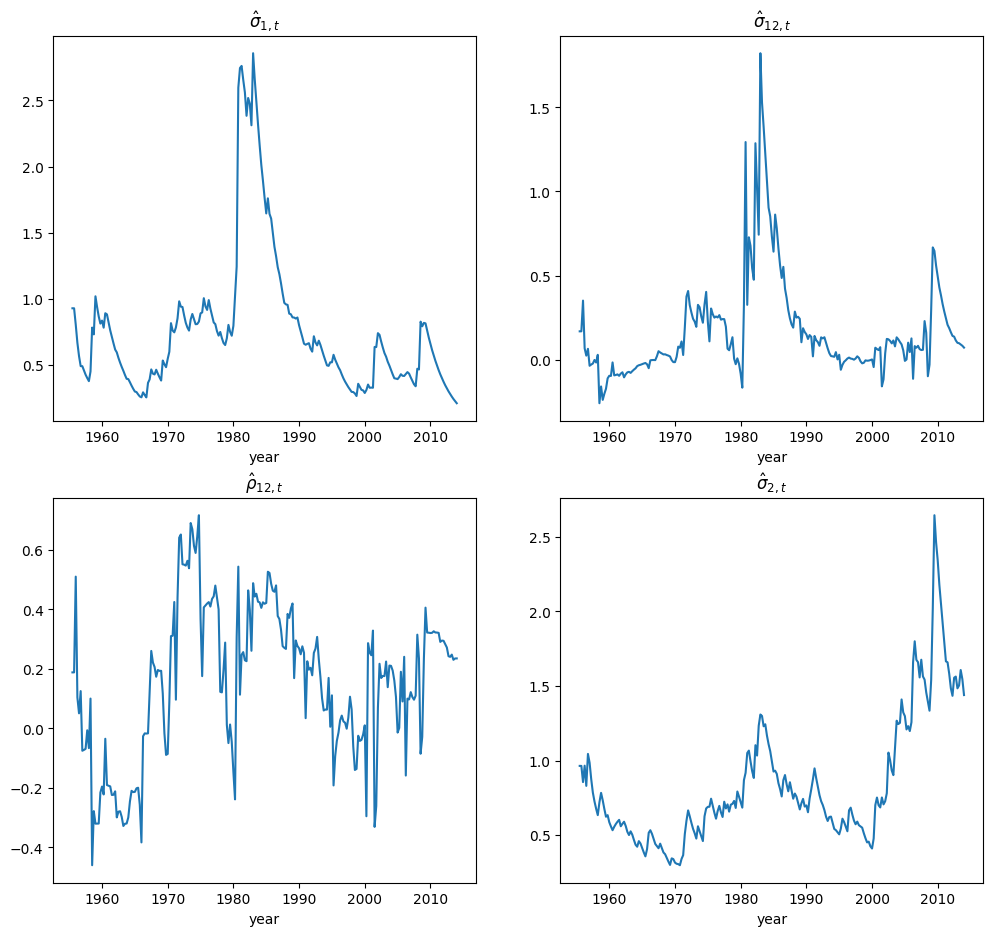

In [94]:
fig, axs = plt.subplots(2, 2, figsize=(12, 11))
plot_sigma(axs[0][0], np.sqrt(ewma_sigma[0, 0, :]), tb_pi_diff.index, '$\\hat{\\sigma}_{1,t}$')
plot_sigma(axs[0][1], ewma_sigma[0, 1, :], tb_pi_diff.index, '$\\hat{\\sigma}_{12,t}$')
plot_sigma(axs[1][0], ewma_sigma[0, 1, :] / np.sqrt(ewma_sigma[0, 0, :] * ewma_sigma[1, 1, :]), tb_pi_diff.index, '$\\hat{\\rho}_{12,t}$')
plot_sigma(axs[1][1], np.sqrt(ewma_sigma[1, 1, :]), tb_pi_diff.index, '$\\hat{\\sigma}_{2,t}$')

#### Problem 9

In [95]:
from sdafe.linalg import matrix_sqrt_inv

In [96]:
def std_residuals(x, sigma_t):
    x = x.values
    res = np.zeros_like(x)
    for t in range(x.shape[0]):
        res[t, :] = x[t, :] @ matrix_sqrt_inv(sigma_t[:, :, t])
    return res

In [97]:
std_res = std_residuals(tb_pi_diff, ewma_sigma)

In [99]:
with np_cv_rules.context():
    MTS.mq(std_res ** 2, lag=8)

Ljung-Box Statistics:  
       m       Q(m)     df    p-value
[1,]   1.0      13.0     4.0     0.01
[2,]   2.0      22.0     8.0     0.00
[3,]   3.0      30.2    12.0     0.00
[4,]   4.0      44.8    16.0     0.00
[5,]   5.0      47.7    20.0     0.00
[6,]   6.0      52.9    24.0     0.00
[7,]   7.0      53.6    28.0     0.00
[8,]   8.0      60.2    32.0     0.00


Based on the results of the Ljung-Box test, the EWMA model is not adequate in terms of removing autocorrelations.

#### Problem 10

In [100]:
from sdafe.ch14.doc import doc_test

In [101]:
doc_test(tb_pi_diff.values ** 2, 8)

,Q(m),d.f.,p-value
m,,,
0,0.954915,1.0,0.328471
1,3.285045,3.0,0.349730
2,3.882399,5.0,0.566469
3,3.986333,7.0,0.781350
4,4.522748,9.0,0.873773
5,4.573323,11.0,0.950060
6,6.302277,13.0,0.934456
7,6.342615,15.0,0.973400
8,7.446695,17.0,0.976994


The test does not reject the null hypothesis that the cross-correlations are jointly zero, so the heteroskedasticity behaviour can be modelled separately.